In [68]:
from nn import nn, io, preprocess
import sklearn.datasets
import numpy as np
import random
import matplotlib.pyplot as plt

In [69]:
def plotLossHistory(per_epoch_loss_val,per_epoch_loss_train):
    epochs = list(range(1,len(per_epoch_loss_val)+1))
    plt.plot(epochs,per_epoch_loss_val,label='validation loss')
    plt.plot(epochs,per_epoch_loss_train,label='training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim((0,per_epoch_loss_train[0] * 1.2))
    plt.legend()
    plt.show()

In [77]:
######AUTOENCODER
#CELL to make train and validation set

#for reproducibility
random_seed = 1
np.random.seed(random_seed)

data = sklearn.datasets.load_digits()['data']
data_shuffled = np.random.permutation(data)
split_index = int(0.8 * len(data_shuffled))
train_set = data_shuffled[:split_index]
validation_set = data_shuffled[split_index:]

X_train = train_set
y_train = train_set
X_val = validation_set
y_val = validation_set


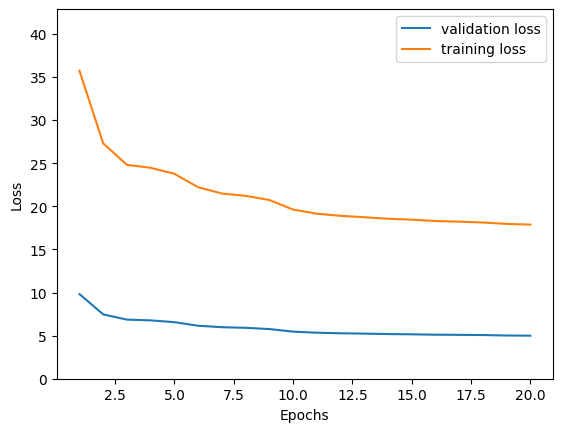

In [78]:
#CELL to generate neural net with hyperparameter explanations

neural_net = nn.NeuralNetwork([{'input_dim': 64, 'output_dim': 16, 'activation': 'sigmoid'}, 
                               {'input_dim': 16, 'output_dim': 64, 'activation': 'relu'}],
                              10,random_seed,100,20,'mean squared error',0.001)

#######HYPER PARAMETER /MODEL EXPLANATIONS############
"""
I use relu activation for the output and MSE loss since my output should be integers > 0. I use sigmoidal input
for layer 2 because it was empirically determined that this model does not learn anything with relu activation
at that layer

My learning rate (10) and lambda (0.001) are very empirically determined. I scan over values on a log scale and see
which ones work best before shifting to a linear scale and doing the same. The batch size is 100 since I want to have ~10 
batches per epoch and I have 1437 samples. 20 epochs is also empirically determined to be where additional training does
not seem to help
"""

per_epoch_loss_train, per_epoch_loss_val = neural_net.fit(X_train,y_train,X_val,y_val)
plotLossHistory(per_epoch_loss_val,per_epoch_loss_train)


In [65]:
#Reconstruction error
y_hat = neural_net.predict(X_val)
errors = []
for i in range(y_hat.shape[0]):
    absolute_error = 0
    for j in range(y_hat.shape[1]):
        absolute_error += abs(y_hat[i][j] - y_val[i][j])
    errors.append(absolute_error / 64)

error = np.average(errors)
print(error)

#I am off each number by an average of 3.2. Idk why it sucks so bad, I tested a lot of parameters
    
    

3.2187258578134736


In [74]:
#######SEQUENCE CLASSIFIER
#CELL to make train and validation set
random.seed(random_seed)

#######Sampling EXPLANATIONS############
"""
This sampling method works by first taking a random 17b sequence from each of the 1kb sequences.
Then, x positive and x negative samples are sampled where x = min(num_positive,num_negative) to all
for the maximum amount of data where there is still the same number of positive and negative samples.
A list of pos:neg samples and labels is made and then shuffled, so the model doesn't learn the pos:neg shape.
"""

#read in samples
positive_seqs = io.read_text_file('data/rap1-lieb-positives.txt')
postive_labels = [1 for x in range(len(positive_seqs))]

#get random substring of each negative seq = length of positive seq
negative_seqs = io.read_fasta_file('data/yeast-upstream-1k-negative.fa')
negative_seqs_truncated = []
for i in range(len(negative_seqs)):
    start_index = random.randint(0,len(negative_seqs[0]) - len(positive_seqs[0]))
    negative_seqs_truncated.append(negative_seqs[0][start_index:start_index + len(positive_seqs[0])])
negative_labels = [0 for x in range(len(negative_seqs_truncated))]

#get same random number of positive and negative seqs
seqs, labels = preprocess.sample_seqs(positive_seqs + negative_seqs_truncated, postive_labels + negative_labels)

#encode sequences
encodings = preprocess.one_hot_encode_seqs(seqs)

#make train and validation sets
X = np.array(encodings)
y = np.array(labels).reshape(1,-1).T
split_index = int(0.8 * X.shape[0])
X_train = X[:split_index]
X_val = X[split_index:]
y_train = y[:split_index]
y_val = y[split_index:]


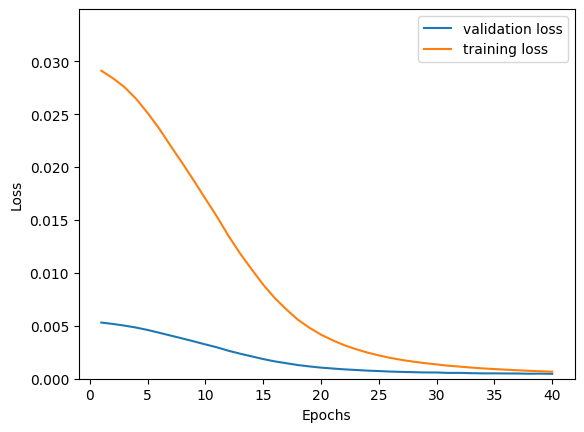

In [75]:
#CELL to generate neural net with hyperparameter explanations

neural_net = nn.NeuralNetwork([{'input_dim': 68, 'output_dim': 17, 'activation': 'relu'}, 
                               {'input_dim': 17, 'output_dim': 1, 'activation': 'sigmoid'}],
                              0.2,random_seed,10,40,'binary cross entropy',0.00001)

#######HYPER PARAMETER /MODEL EXPLANATIONS############
"""
This model first has 68 input features, for 4 digits x 17 bases. This is processes to a 17 input hidden layer,
corresponding to the bases. This has a Relu activation so the model sums up the encodings. This hidden layer
theoretically stores how the model learns to go from encoding -> base. Then this 17 feature layer is processed
to a 1 layer sigmoidal output, corresponding to a prediction of binding site or not binding site. Since my output y
is 0 or 1 in the data, I use BCE loss.

My learning rate (0.2) and lambda (0.00001) are empirically determined. I scan over values on a log scale and see
which ones work best before shifting to a linear scale and doing the same. The batch size is 10 since I want to have 
~on the order of 10 batches per epoch and I have 137 samples. 40 epochs is also empirically determined to be 
where additional training does not seem to help
"""

per_epoch_loss_train, per_epoch_loss_val = neural_net.fit(X_train,y_train,X_val,y_val)
plotLossHistory(per_epoch_loss_val,per_epoch_loss_train)